In [1]:
import os
from typing import Tuple, List, Sequence, Callable, Dict

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import KeypointRCNN

import albumentations as A
from albumentations.pytorch import ToTensorV2

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('test.csv', index_col='image')
df.head()

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,...,10_x,10_y,11_x,11_y,12_x,12_y,13_x,13_y,14_x,14_y
image,,,,,,,,,,,,,,,,,,,,,
20201028_cat-arch-000156.mp4/frame_0_timestamp_0.jpg,563,600,553,503,504,505,504,505,506,507,...,718,694,676,699,773,695,775,562,862,640
20201028_cat-arch-000156.mp4/frame_12_timestamp_800.jpg,554,536,548,450,451,452,451,452,453,454,...,720,693,671,723,771,731,782,568,866,636
20201028_cat-arch-000156.mp4/frame_15_timestamp_1000.jpg,559,1071,483,931,932,933,932,933,347,829,...,678,962,963,964,772,1021,696,655,882,445
20201028_cat-arch-000156.mp4/frame_102_timestamp_6800.jpg,502,1016,435,888,889,890,889,890,295,785,...,610,879,880,881,754,959,607,594,866,530
20201028_cat-arch-000156.mp4/frame_105_timestamp_7000.jpg,411,1024,344,903,904,905,904,905,231,800,...,516,857,858,859,627,895,537,564,813,598


### 1. 데이터셋 전처리 및 시각화

In [3]:
def draw_keypoints(
    image: np.ndarray,
    keypoints: np.ndarray,
    edges: List[Tuple[int, int]] = None,
    keypoint_names: Dict[int, str] = None, 
    boxes: bool = True,
    dpi: int = 200
) -> None:
    """
    Args:
        image (ndarray): [H, W, C]
        keypoints (ndarray): [N, 3]
        edges (List(Tuple(int, int))): 
    """
    np.random.seed(42)
    colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}

    if boxes:
        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

    for i, keypoint in enumerate(keypoints):
        cv2.circle(
            image, 
            tuple(keypoint), 
            3, colors.get(i), thickness=3, lineType=cv2.FILLED)

        if keypoint_names is not None:
            cv2.putText(
                image, 
                f'{i}: {keypoint_names[i]}', 
                tuple(keypoint), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    if edges is not None:
        for i, edge in enumerate(edges):
            cv2.line(
                image, 
                tuple(keypoints[edge[0]]), 
                tuple(keypoints[edge[1]]),
                colors.get(edge[0]), 3, lineType=cv2.LINE_AA)

    fig, ax = plt.subplots(dpi=dpi)
    ax.imshow(image)
    ax.axis('off')
    plt.show()
    fig.savefig('example.png')

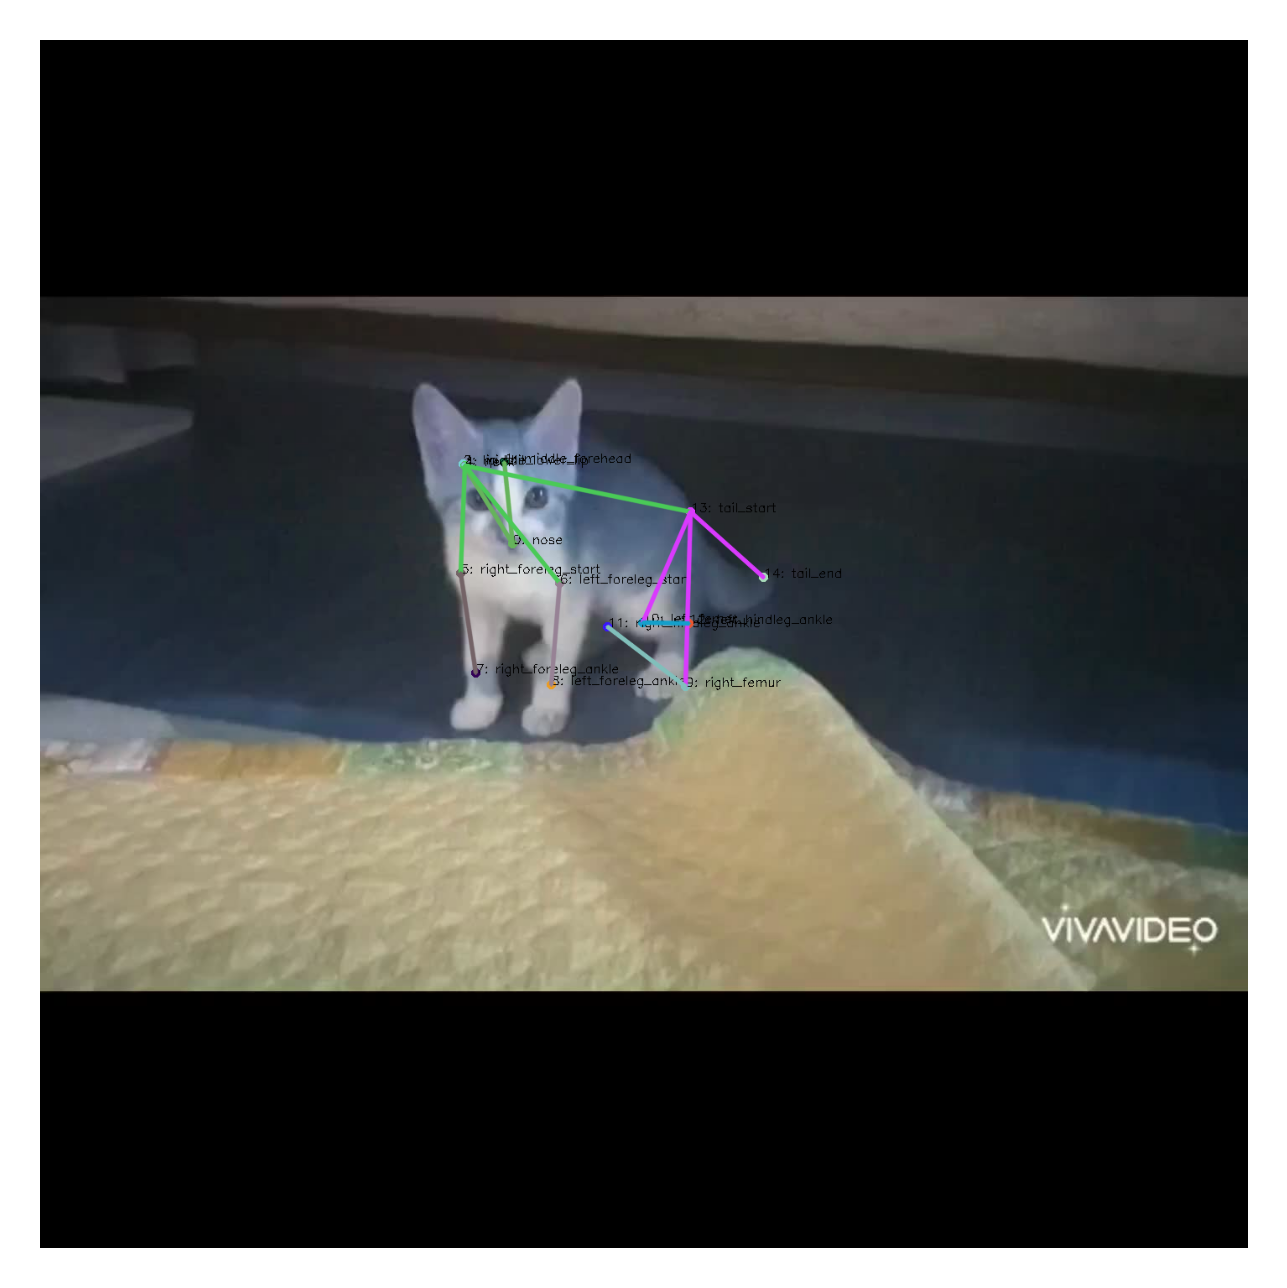

In [4]:
keypoints = df.iloc[0, 0:].values.reshape(-1, 2)
keypoints = keypoints.astype(np.int64)
keypoint_names = {
          0: 'nose', 1: 'middle_forehead', 2: 'lip_tail', 3: 'middle_lower_lip', 4: 'neck',
          5: 'right_foreleg_start', 6: 'left_foreleg_start', 7: 'right_foreleg_ankle', 8: 'left_foreleg_ankle',
          9: 'right_femur', 10: 'left_femer', 11: 'right_hindleg_ankle', 12: 'left_hindleg_ankle',
          13: 'tail_start', 14: 'tail_end',
}

edges = [
          (0, 1),  (0,3), (2,3), (3, 4), (4, 5),
          (4, 6), (5, 7), (6, 8), (4, 13), (13, 9), 
          (13, 10), (13,14), (9, 11), (10,12)
]

image = cv2.imread('./20201028_cat-arch-000156.mp4/frame_0_timestamp_0.jpg', cv2.COLOR_BGR2RGB)
draw_keypoints(image, keypoints, edges, keypoint_names, boxes=False, dpi=400)

### 2. TorchVision 모형을 이용한 추론

In [5]:
image = cv2.imread('./20201028_cat-arch-000156.mp4/frame_0_timestamp_0.jpg', cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1333, 800))
image = image / 255.0
image = image.transpose(2, 0, 1)
image = [torch.as_tensor(image, dtype=torch.float32)]

model = keypointrcnn_resnet50_fpn(pretrained=True, progress=False)
model.eval()
preds = model(image)
preds[0].keys()

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])

In [6]:
keypoints = preds[0]['keypoints'].detach().numpy().copy()[0]
image = cv2.imread('./20201028_cat-arch-000156.mp4/frame_0_timestamp_0.jpg', cv2.COLOR_BGR2RGB)
keypoints[:, 0] *= image.shape[1]/1333
keypoints[:, 1] *= image.shape[0]/800
keypoints = keypoints[:, :2]

edges = [
          (0, 1),  (0,3), (2,3), (3, 4), (4, 5),
          (4, 6), (5, 7), (6, 8), (4, 13), (13, 9), 
          (13, 10), (13,14), (9, 11), (10,12)
]

draw_keypoints(image, keypoints, edges, boxes=False)

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type


### 3. Keypoint R-CNN 학습하기

In [7]:
class KeypointDataset(Dataset):
    def __init__(
        self,
        image_dir: os.PathLike,
        label_path: os.PathLike,
        transforms: Sequence[Callable]=None
    ) -> None:
        self.image_dir = image_dir
        self.df = pd.read_csv(label_path)
        self.transforms = transforms

    def __len__(self) -> int:
        return self.df.shape[0]
    
    def __getitem__(self, index: int) -> Tuple[Tensor, Dict]:
        image_id = self.df.iloc[index, 0]
        labels = np.array([1])
        keypoints = self.df.iloc[index, 1:].values.reshape(-1, 2).astype(np.int64)

        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        boxes = np.array([[x1, y1, x2, y2]], dtype=np.int64)

        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.COLOR_BGR2RGB)

        targets ={
            'image': image,
            'bboxes': boxes,
            'labels': labels,
            'keypoints': keypoints
        }

        if self.transforms is not None:
            targets = self.transforms(**targets)

        image = targets['image']
        image = image / 255.0

        targets = {
            'labels': torch.as_tensor(targets['labels'], dtype=torch.int64),
            'boxes': torch.as_tensor(targets['bboxes'], dtype=torch.float32),
            'keypoints': torch.as_tensor(
                np.concatenate([targets['keypoints'], np.ones((24, 1))], axis=1)[np.newaxis], dtype=torch.float32
            )
        }

        return image, targets

In [8]:
transforms = A.Compose([
    ToTensorV2()
],  bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
    keypoint_params=A.KeypointParams(format='xy')
)

In [10]:
def collate_fn(batch: torch.Tensor) -> Tuple:
    return tuple(zip(*batch))


trainset = KeypointDataset('./20201028_cat-arch-000156.mp4/frame_0_timestamp_0.jpg', './test.csv', transforms)
train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=8, collate_fn=collate_fn)

In [11]:
from torchvision.models.detection.anchor_utils import AnchorGenerator
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

def get_model() -> nn.Module:
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )

    keypoint_roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=14,
        sampling_ratio=2
    )

    model = KeypointRCNN(
        backbone, 
        num_classes=2,
        num_keypoints=24,
        box_roi_pool=roi_pooler,
        keypoint_roi_pool=keypoint_roi_pooler,
        rpn_anchor_generator=anchor_generator
    )

    return model

In [12]:
def train(device='cuda:0'):
    model = get_model()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for i, (images, targets) in enumerate(train_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            optimizer.zero_grad()
            losses = model(images, targets)
    
            loss = sum(loss for loss in losses.values())
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print(f'| epoch: {epoch} | loss: {loss.item():.4f}', end=' | ')
                for k, v in losses.items():
                    print(f'{k[5:]}: {v.item():.4f}', end=' | ')
                print()

### 4. 학습한 모형에서 추론

In [13]:
image = cv2.imread('./20201028_cat-arch-000156.mp4/frame_0_timestamp_0.jpg', cv2.COLOR_BGR2RGB)
image = image / 255.0
image = image.transpose(2, 0, 1)
image = [torch.as_tensor(image, dtype=torch.float32)]

model = get_model()
model.load_state_dict(torch.load('model-e39.pth'))
model.eval()
preds = model(image)
keypoints = preds[0]['keypoints'].detach().numpy().copy()[0]
image = cv2.imread('./20201028_cat-arch-000156.mp4/frame_0_timestamp_0.jpg', cv2.COLOR_BGR2RGB)
keypoints = keypoints[:, :2]

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (9, 18),
    (10, 19), (5, 7), (7, 9), (11, 13), (13, 15), (12, 14),
    (14, 16), (15, 22), (16, 23), (20, 21), (5, 6), (5, 11),
    (6, 12), (11, 12), (17, 20), (20, 21), 
]

draw_keypoints(image, keypoints, edges, boxes=False)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to p

FileNotFoundError: [Errno 2] No such file or directory: 'model-e39.pth'